## 2D Sliding Window

<p> Motive: To create a robuts 2d sliding window to remove blocking and to generate training sets of fixed size for CNN. <p>
<p>Objective: A Non overlaping window (inner) which moves over the gather and a bigger (outer) window of the fixed size which covers the inner window and  overlap.<p> 
<p> Difficulties faced: At the starting edge and inner edge .<p> 
<p> Read the definination of the function for intricate details.<p> 

### Tools

In [2]:
import random
import os
import sys
import warnings
import datetime

from tqdm import tqdm

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import numpy.matlib
from numpy.fft import fft, ifft

import matplotlib.pyplot as plt

import scipy
from scipy.signal import butter, filtfilt
from scipy.stats import norm
import scipy.io


import segyio

from skimage.metrics import structural_similarity as ssim
# from skimage.measure import compare_ssim 
from skimage.metrics import peak_signal_noise_ratio as psnr

from sklearn.preprocessing import StandardScaler

In [3]:
def myStrongFilter(data,flp,fhi,delt):
    #data - input time series
    #flp - lowpass corner freq of filter
    #fhi - highpass corner freq
    #delt - sampling interval of the data
    
    flp = flp
    fhi = fhi
    
    Fs = 1/delt
    Nyq = Nyq = Fs/2
    
    Data_Freq = np.fft.fft(data)
    Filter = np.ones(Data_Freq.shape)
    Filter[:,int(np.ceil((flp/Nyq)*Data_Freq.shape[0])):int(np.ceil((fhi/Nyq)*Data_Freq.shape[0]))] = 0
    Filter[:,-int(np.ceil((fhi/Nyq)*Data_Freq.shape[0])):-int(np.ceil((flp/Nyq)*Data_Freq.shape[0]))] = 0

    Data_Freq_Filt = Data_Freq*Filter
    
    return np.real(ifft(Data_Freq_Filt))

### Slidding Window

In [4]:
## inner window as a part of outer window - First define outer window and inner window as a part of outer window
### File location:
path = 'C:/Users/Ssach/OneDrive - Delft University of Technology/AGP/Thesis/Github/Sparse Solver/'  
filename = 'NoSI.segy'
tot_x,tot_y = 636,1600
out_x,out_y = 64,256
factor_x,factor_y = 8,8
part_x,part_y = 4,4
inn_x,inn_y = int(out_x/factor_x),int(out_y/factor_y)

overlap_x,overlap_y = inn_x,inn_y

num_windows_x,num_windows_y= int(np.ceil(tot_x/inn_x)), int(np.ceil(tot_y/inn_y))
num_windows =  num_windows_x*num_windows_y 

INN_windows = np.zeros((num_windows,inn_x,inn_y,1))
OUT_windows = np.zeros((num_windows,out_x,out_y,1))
OUT_windows_filtered = np.zeros((num_windows,out_x,out_y,1))
OUT_windows_norm = np.zeros((num_windows,out_x,out_y,1))
Normalized_factor = []
with segyio.open(path + filename, ignore_geometry=True) as f:

    count =0
    gather = f.trace.raw[:][0:tot_x,0:tot_y]
    gather_filtered = myStrongFilter(gather,20,30,delt=0.004)
    for i in range (0,tot_x,inn_x):  ## Loop over traces - x direction
        ## Outer Window - X direction
        ox_s = int(np.min([np.max([0,i-part_x*overlap_x]),tot_x])) #int(np.min([np.max([0,i-overlap_x]),tot_x]))
        ox_e =   ox_s + out_x
        if ox_e > tot_x:
            ox_s = tot_x -out_x
            ox_e = tot_x
        ## Inner window - X direction
        ix_s = part_x*overlap_x
        if i <= part_x*overlap_x:
            ix_s = i
        if i >= tot_x - (factor_x-part_x)*inn_x:
            ix_s = int((factor_x - np.ceil((tot_x-i)/inn_x))*inn_x)
        ix_e = ix_s+inn_x
        
        for j in range (0,tot_y,inn_y):  ## Loop over traces - x direction

            ## Outer Window - X direction
            oy_s = int(np.min([np.max([0,j-part_y*overlap_y]),tot_y])) #int(np.min([np.max([0,i-overlap_x]),tot_x]))
            oy_e =   oy_s + out_y
            if oy_e > tot_y:
                oy_s = tot_y -out_y
                oy_e = tot_y
            ## Inner window - X direction
            iy_s = part_y*overlap_y
            if j <= part_y*overlap_y:
                iy_s = j
            if j >= tot_y - (factor_y-part_y)*inn_y:
                iy_s = int((factor_y - np.ceil((tot_y-j)/inn_y))*inn_y)

            iy_e = iy_s+inn_y
            
            

            outer_window = gather[ox_s:ox_e,oy_s:oy_e]
            inner_window = outer_window[ix_s:ix_e,iy_s:iy_e]
            INN_windows[count] = inner_window.reshape((inn_x,inn_y,1))

            ## Function of be formed on outer window - and outter windows to be the only output
            outer_window_filt = gather_filtered[ox_s:ox_e,oy_s:oy_e]
            normfac = np.max(np.abs((outer_window)))
            Normalized_factor.append(normfac)
            outer_window_norm = ( (outer_window / normfac) +1 ) / 2

            
            OUT_windows[count] = outer_window.reshape((out_x,out_y,1))
            OUT_windows_filtered[count] = outer_window_filt.reshape((out_x,out_y,1))
            OUT_windows_norm[count] = outer_window_norm.reshape((out_x,out_y,1))

            count =count+1 
            
        
        
        
   

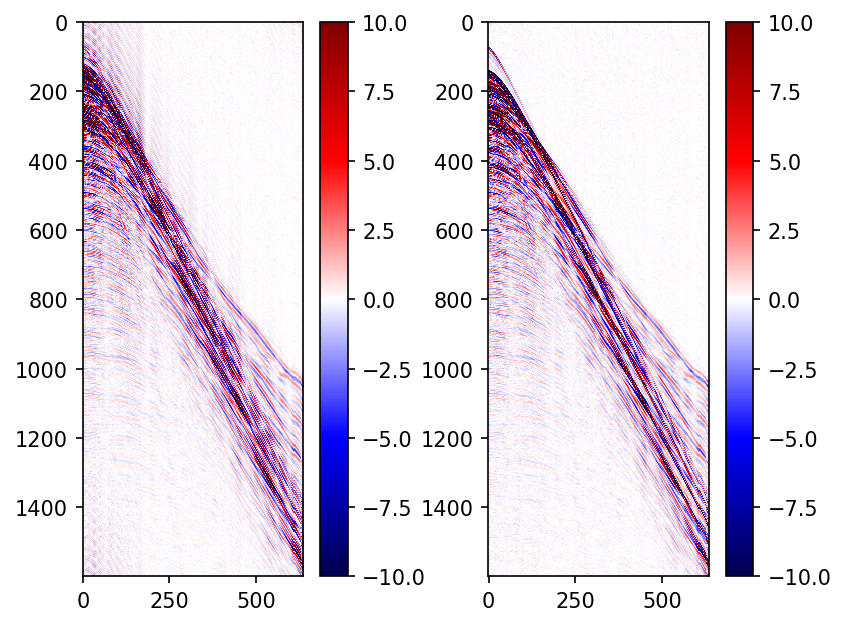

In [5]:
Output = np.zeros((tot_x,tot_y))
Output_filtered = np.zeros((tot_x,tot_y))
Output_norm= np.zeros((tot_x,tot_y))
count = 0

for i in range (0,tot_x,inn_x):
    if i <= part_x*inn_x:
        x_s = i
    if i > part_x*inn_x:
        x_s = part_x*inn_x
    if i >= tot_x - (factor_x-part_x)*inn_x:
        x_s = int((factor_x - np.ceil((tot_x-i)/inn_x))*inn_x)
    x_e = x_s +inn_x

    for j in range (0,tot_y,inn_y):
        if j <= part_y*inn_y:
            y_s = j
        if j > part_y*inn_y:
            y_s = part_y*inn_y
        if j >= tot_y - (factor_y-part_y)*inn_y:
            y_s = int((factor_y - np.ceil((tot_y-j)/inn_y))*inn_y)
        y_e = y_s + inn_y
        
        a = OUT_windows[count,:,:]
        c = OUT_windows_filtered[count,:,:]
        b = OUT_windows_norm[count,:,:]

        a = a.reshape((out_x,out_y))
        b =  b.reshape((out_x,out_y))
        c =  c.reshape((out_x,out_y))
        a = a[x_s:x_e,y_s:y_e]
        c = c[x_s:x_e,y_s:y_e]
        b = b[x_s:x_e,y_s:y_e]
        b = ( (b *2) -1 )*Normalized_factor[count]


       
        ox_s = i
        ox_e = i+inn_x
        if ox_e > tot_x:
            ox_s = tot_x -inn_x
            ox_e = tot_x 
        oy_s = j
        oy_e = j+inn_y
        if oy_e > tot_y:
            oy_s = tot_y -inn_y
            oy_e = tot_y 

        Output[ox_s:ox_e,oy_s:oy_e] = a
        Output_filtered[ox_s:ox_e,oy_s:oy_e] = c
        Output_norm[ox_s:ox_e,oy_s:oy_e] = b
        
        count = count+1

plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.imshow((Output_filtered).T,cmap='seismic',vmax=10,vmin=-10)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow((Output_norm).T,cmap='seismic',vmax=10,vmin=-10)
plt.colorbar()
        

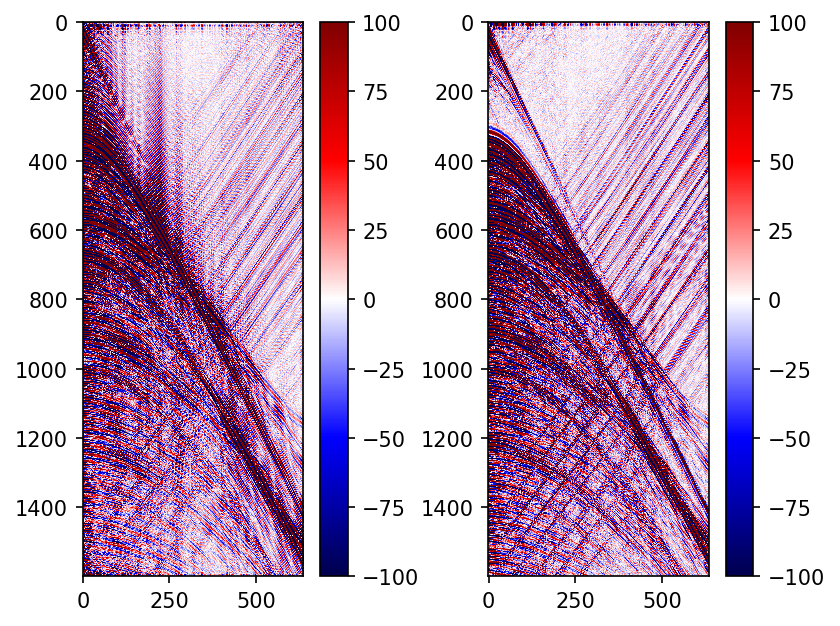

In [10]:
path = 'C:/Users/Ssach/OneDrive - Delft University of Technology/AGP/Thesis/Github/Neural Network/' 
filename = 'IRP1909132tlaa.P_s1_c5_LC.sgy'

with segyio.open(path + filename, ignore_geometry=True) as f:

    
    gather = f.trace.raw[:][0:tot_x,0:tot_y]
    gather_filt = myStrongFilter(gather,20,35,0.004)
plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.imshow((gather_filt).T,cmap='seismic',vmax=100,vmin=-100)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow((gather).T,cmap='seismic',vmax=100,vmin=-100)
plt.colorbar()
        